In [1]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np #Numerical operations and array manipulation
import pandas as pd #Data manipulation and analysis using data frames.

# Importing libraries for data visualization
import matplotlib.pyplot as plt #Plotting library for creating visualizations.
import matplotlib.ticker as mtick #Ticker module for controlling axis ticks in visualizations.
import matplotlib.gridspec as grid_spec #Gridspec module for creating customized subplot layouts.
import seaborn as sns #Statistical data visualization library for enhancing the aesthetics of plots.

# Importing SMOTE for handling imbalanced datasets (Technique for handling imbalanced datasets by oversampling the minority class.)
from imblearn.over_sampling import SMOTE

# Importing scikit-plot for creating various machine learning-related visualizations
import scikitplot as skplt

# Importing machine learning modules for building and evaluating models
from sklearn.pipeline import Pipeline #Tool for streamlining machine learning workflows.
# sklearn.preprocessing.StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
# sklearn.preprocessing.LabelEncoder: Encodes categorical labels with numerical values.
from sklearn.preprocessing import StandardScaler, LabelEncoder
# sklearn.model_selection.train_test_split: Splits the dataset into training and testing sets.
# sklearn.model_selection.cross_val_score: Performs cross-validation to evaluate model performance.
from sklearn.model_selection import train_test_split, cross_val_score

# Importing regression models for predicting continuous outcomes
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Importing classification models for predicting categorical outcomes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Importing metrics for evaluating classification model performance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

# Suppressing unnecessary warnings during code execution
import warnings
warnings.filterwarnings('ignore')

# Installing the pywaffle package for creating waffle charts
!pip install pywaffle


In [2]:
# Reading a CSV file named 'healthcare-dataset-stroke-data.csv' into a Pandas DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Displaying the first few rows of the DataFrame to get an initial overview of the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Missing Data

In [3]:
# Checking for missing values in each column of the DataFrame
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# How can we deal with blanks in our data?

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways.

Here I will use a <b> Decision Tree to predict the missing BMI</b>

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [4]:
# Creating a pipeline for Decision Tree Regression to impute missing 'bmi' values
DT_bmi_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),         # Step 1: Standardize features using StandardScaler
    ('lr', DecisionTreeRegressor(random_state=42))  # Step 2: Decision Tree Regression model
])

# Extracting relevant features from the DataFrame
X = df[['age', 'gender', 'bmi']].copy()

# Mapping categorical 'gender' values to numerical values
X['gender'] = X['gender'].replace({'Male': 0, 'Female': 1, 'Other': -1}).astype(np.uint8)

# Separating rows with missing 'bmi' values for imputation
Missing = X[X['bmi'].isna()]
X = X[~X['bmi'].isna()]
Y = X.pop('bmi')

# Fitting the Decision Tree Regression model to the existing data
DT_bmi_pipe.fit(X, Y)

# Predicting missing 'bmi' values and updating the DataFrame
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]), index=Missing.index)
df.loc[Missing.index, 'bmi'] = predicted_bmi

In [5]:
# Checking and printing the total count of missing values in the DataFrame
print('Missing values: ', sum(df.isnull().sum()))

Missing values:  0


## Exploring the data

This is the next step after dealing with the missing values in the dataset.

Next, is the EDA stands for Exploratory Data Analysis, which is a crucial step in the data analysis process.

Here, we try to answer different questions like: <br>
Does age makes one more likely to suffer a stroke? What about gender? Or BMI?

These are all questions that can be explored and answered with some data visulization.

First, let's look at the numeric/continuous variable distribtion

In [6]:
# Extracting all columns except 'id' and 'stroke' into the 'variables' list
variables = [variable for variable in df.columns if variable not in ['id', 'stroke']]

# Selecting specific continuous variables into the 'conts' list
conts = ['age', 'avg_glucose_level', 'bmi']


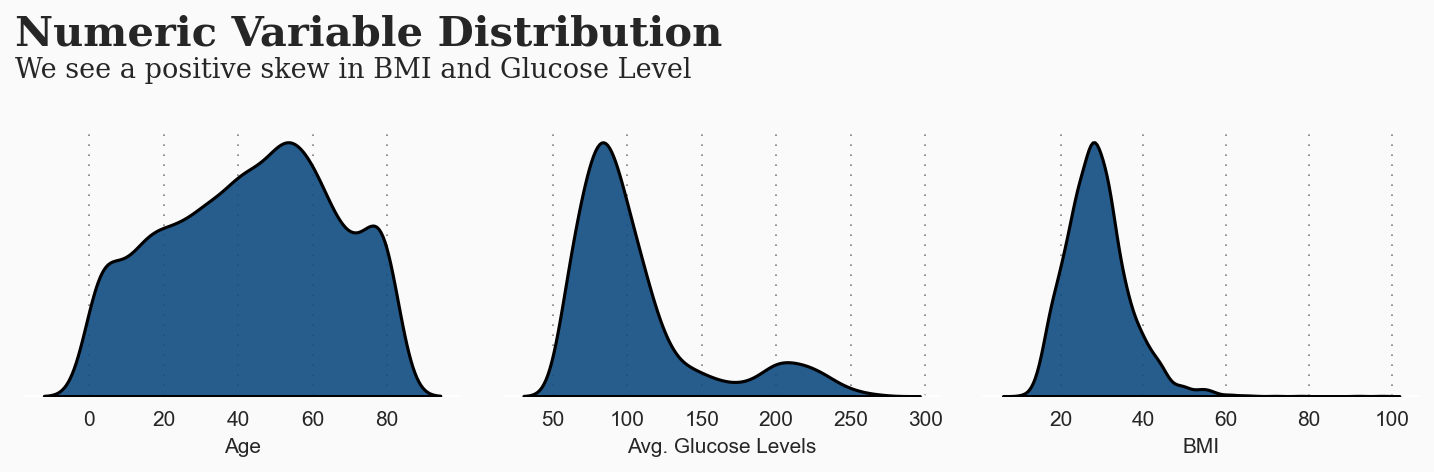

In [7]:
# Setting up the figure with a 1x3 grid
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

# Setting background color
background_color = "#fafafa"

# Initializing subplots
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        # Creating individual subplots with a consistent background color
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)

        # Removing y-axis ticks and spines for aesthetics
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top", "right", "left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)

        # Incrementing plot index
        plot += 1

# Plotting kernel density estimation (KDE) plots for continuous variables
plot = 0
for variable in conts:
    # Creating KDE plots for each continuous variable, with specified styling
    sns.kdeplot(df[variable], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black', alpha=0.9, zorder=3, legend=False)

    # Adding grid lines for better visualization
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1, 5))

    # Incrementing plot index
    plot += 1

# Setting individual x-axis labels for each subplot
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

# Adding title and annotation for better context
ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

# Displaying the plot
plt.show()

Let's see how the distribution of our numeric variables is different for those that have strokes, and those that do not.

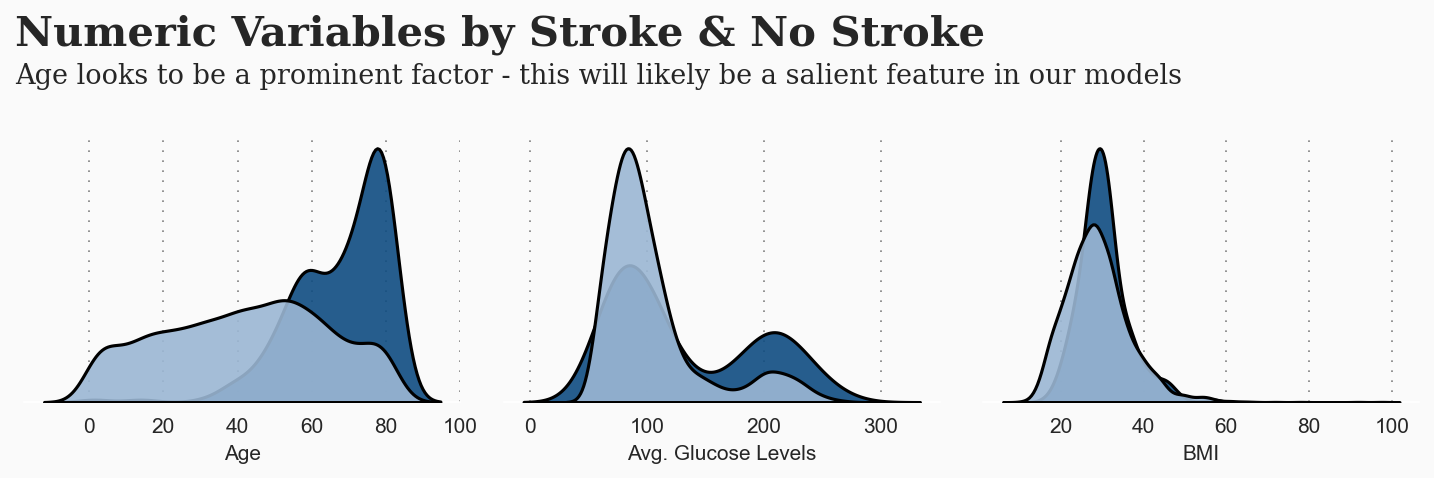

In [8]:
# Setting up the figure with a 1x3 grid and background color
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

# Initializing subplots
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        # Creating individual subplots with consistent background color
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)

        # Removing y-axis ticks and spines for aesthetics
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top", "right", "left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)

        # Incrementing plot index
        plot += 1

# Plotting kernel density estimation (KDE) plots for continuous variables separated by 'stroke' status
plot = 0
s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
    # Creating KDE plots for 'stroke' and 'no stroke' groups for each continuous variable
    sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black', alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(ns[feature], ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black', alpha=0.9, zorder=3, legend=False)

    # Adding grid lines for better visualization
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1, 5))

    # Incrementing plot index
    plot += 1

# Setting individual x-axis labels for each subplot
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

# Adding title and annotation for better context
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feature in our models',
         fontsize=13, fontweight='light', fontfamily='serif')

# Displaying the plot
plt.show()

# Insight

Based on the above plots, it seems clear that Age is a big factor in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.

Let's explore those variables further...

In [9]:
# Creating two separate DataFrames based on 'stroke' status
str_only = df[df['stroke'] == 1]  # DataFrame for instances with stroke
no_str_only = df[df['stroke'] == 0]  # DataFrame for instances without stroke

TypeError: object of type 'NoneType' has no len()

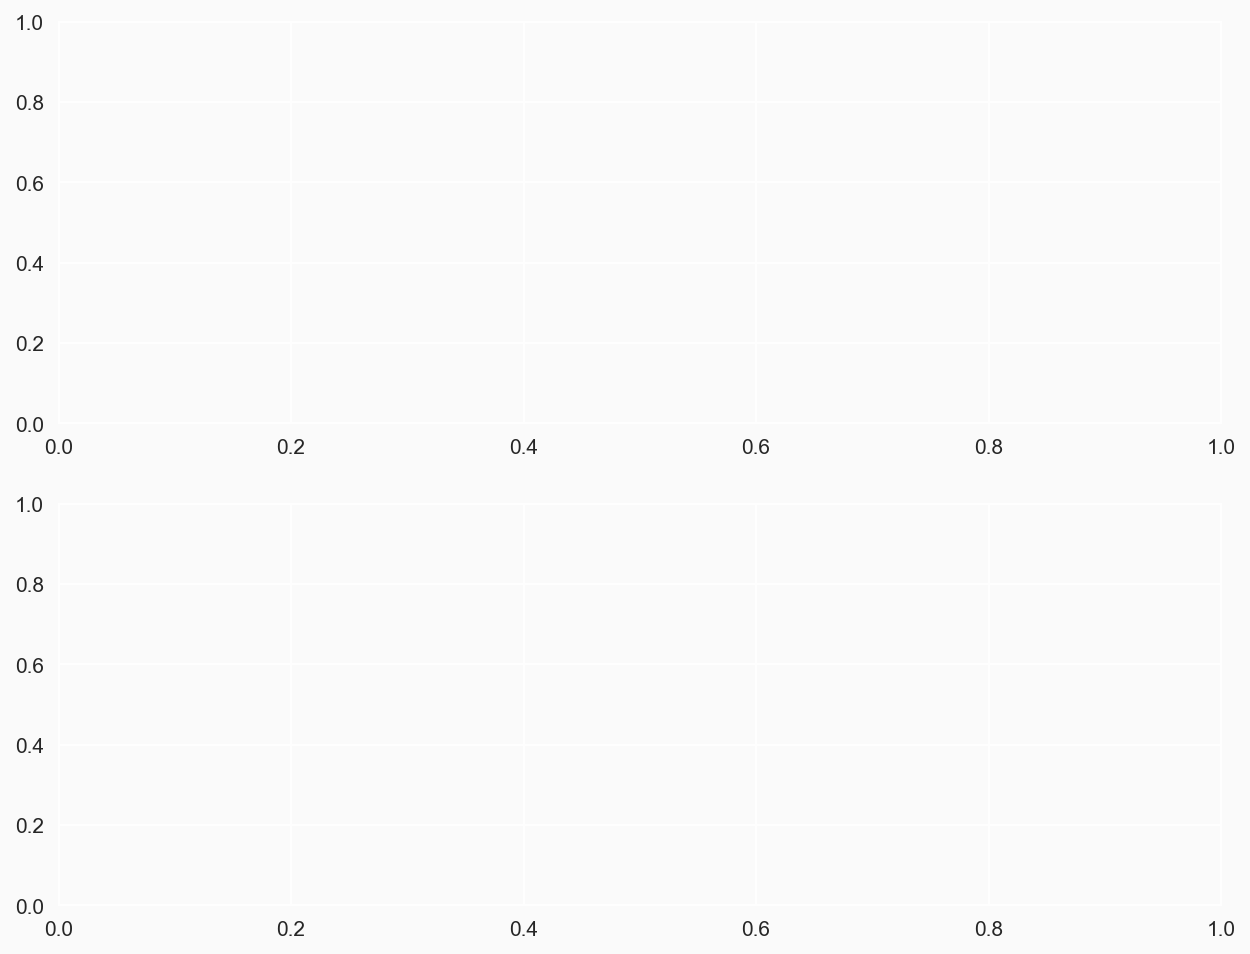

In [10]:
fig = plt.figure(figsize=(10,16),dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2])

ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# glucose

sns.regplot(no_str_only['age'],y=no_str_only['avg_glucose_level'],
            color='lightgray',
            logx=True,
            ax=ax0)

sns.regplot(str_only['age'],y=str_only['avg_glucose_level'],
            color='#0f4c81',
            logx=True,scatter_kws={'edgecolors':['black'],
                                   'linewidth': 1},
            ax=ax0)

ax0.set(ylim=(0, None))
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')

ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False)

for s in ['top','left','bottom']:
    ax0.spines[s].set_visible(False)


# bmi
sns.regplot(no_str_only['age'],y=no_str_only['bmi'],
            color='lightgray',
            logx=True,
            ax=ax1)

sns.regplot(str_only['age'],y=str_only['bmi'],
            color='#0f4c81', scatter_kws={'edgecolors':['black'],
                                          'linewidth': 1},
            logx=True,
            ax=ax1)

ax1.set_xlabel("Age",fontsize=10,fontfamily='serif',loc='left')
ax1.set_ylabel("BMI",fontsize=10,fontfamily='serif',loc='bottom')


for s in ['top','left','right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)


ax0.text(-5,350,'Strokes by Age, Glucose Level, and BMI',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-5,320,'Age appears to be a very important factor',fontsize=14,fontfamily='serif')


ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)



plt.show()